<a href="https://colab.research.google.com/github/sadiemir/IMDB_Sentiment_Analysis_WEmbeddings/blob/main/IMDB_Sentiment_Analysis_Word_Embeddings_GColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Step 1: Load and Preprocess the data

In [25]:
#Load the IMDB dataset
from datasets import load_dataset

#Load the imdb dataset
imdb_dataset = load_dataset("imdb")

# Take a small subset for training and testing to keep things manageable
train_data = imdb_dataset['train'].shuffle(seed=42).select(range(1000))
test_data = imdb_dataset['test'].shuffle(seed=42).select(range(500))

In [26]:
# import necessary libraries for NLP processing
import nltk
from nltk.tokenize import TreebankWordTokenizer #for breaking text into words
from nltk.stem import PorterStemmer, WordNetLemmatizer #for stemming and lemmatization
from nltk.corpus import wordnet, stopwords #for accessing word meaning and stopwords
from nltk import pos_tag #for part of speech tagging

#download required resources for tokenization, lemmatization, and stop words removal
nltk.data.path.append('/Users/smirghor/nltk_data')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') #POS tagger for lemmatization
nltk.download('stopwords') #stop words list

#innitialize the stemmer and lemmatizer
tokenizer = TreebankWordTokenizer()
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) #define a set of common english stop words


# Function to convert POS tags to a format suitable for WordNet lemmatization
def get_wordnet_pos(tag):
    # Map POS tag to WordNet format for accurate lemmatization
    if tag.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif tag.startswith('R'):
        return wordnet.ADV  # Adverb
    else:
        return wordnet.NOUN  # Default to noun if unknown


# Function to preprocess a given text
def preprocess_text(text):
    # 1. tokenize the text into words
    tokens = tokenizer.tokenize(text)
    # 2. apply stemming
    tokens = [stemmer.stem(token) for token in tokens if token.isalpha()]
    #3. apply lemmatization
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(pos_tag([token])[0][1])) for token in tokens]
    #4. remove stop words
    tokens = [token for token in tokens if token.lower() not in stop_words]
    # join the token back into a single string and return it
    return ' '.join(tokens)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
#Apply preprocessing to the training data
Preprocessed_train_data= [preprocess_text(review['text']) for review in train_data]
preprocessed_test_data = [preprocess_text(review['text']) for review in test_data]

#Extract the laels (0=Negative, 1=Positive)
y_train = [review['label'] for review in train_data]
y_test = [review['label'] for review in test_data]

#### Step 2: Convert preprocessed reviews to Vectors uning GloVe

In [28]:
#	1.	Load GloVe Embeddings:
import numpy as np

#Define a function to load Glove embeddings
def load_glove_embeddings(file_path):
    embeddings_index = {} # Dictionary to store the word vectors
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split() # Split the line into word and coefficients
            word = values[0] # The word is the first value
            vector = np.asarray(values[1:], dtype='float32') # Coefficients are the rest of the values
            embeddings_index[word] = vector # Store the word and its vector in the dictionary
    return embeddings_index



In [29]:

from google.colab import files
uploaded = files.upload()



Saving glove.6B.100d.txt to glove.6B.100d (1).txt


In [30]:

#Load Glove embeddings (adjust the path as needed)
glove_file_path = 'glove.6B.100d.txt'

# Load the embeddings into the 'embeddings_index' variable
embeddings_index = load_glove_embeddings(glove_file_path)

# Print the number of words loaded
print(f"Loaded {len(embeddings_index)} word vectors.")

Loaded 400000 word vectors.


In [34]:
# 2. Convert Reviews to Vectors:
# function to convert a review into an average vector using GloVe
def review_to_vector(review, embedding, dim=100):
    words = review.split() #split reviews into individual words
    word_vectors = [embedding[word] for word in words if word in embedding]
    if len(word_vectors) ==0:
        return np.zeros(dim) #Return a zero vector if no words have embeddings
    return np.mean(word_vectors, axis=0) #Average the vectors

#Apply this function to training and test data
X_train_vectors = np.array([review_to_vector(review, embeddings_index) for review in Preprocessed_train_data])
X_test_vectors = np.array([review_to_vector(review, embeddings_index) for review in preprocessed_test_data])

#Check the shape of the training vector
print(f"Training Data Vector Shape: {X_train_vectors.shape}")

Training Data Vector Shape: (1000, 100)


#### Step 3: Build and train a neural network model

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#Define a simple neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(100,)), #Input layer with 32 neuron, and ReLu activation
    Dense(32, activation='relu'), #Hidden layer with 16 neuron
    Dense(1, activation='sigmoid') #Output layer with sigmoid for binary classification
])

#Compile the model with binary cross-entropy loss and the Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Train the model using the training vectors
history = model.fit(X_train_vectors, np.array(y_train), epochs=10, batch_size=8, validation_split=0.2)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5820 - loss: 0.6846 - val_accuracy: 0.7300 - val_loss: 0.6396
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6674 - loss: 0.6277 - val_accuracy: 0.7500 - val_loss: 0.5701
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7098 - loss: 0.5744 - val_accuracy: 0.6850 - val_loss: 0.5653
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7355 - loss: 0.5372 - val_accuracy: 0.7600 - val_loss: 0.5111
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7363 - loss: 0.5435 - val_accuracy: 0.7900 - val_loss: 0.4997
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7606 - loss: 0.5017 - val_accuracy: 0.7800 - val_loss: 0.4896
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7892 - loss: 0.4754 - val_accuracy: 0.7100 - val_loss: 0.5810
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7770 - loss: 0.4742 - val_accuracy: 0.7950 - val_

#### Step 4: Evaluate the Model


In [36]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_vectors, np.array(y_test))
print(f"Test Accuracy: {test_accuracy:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7223 - loss: 0.5761  
Test Accuracy: 0.73


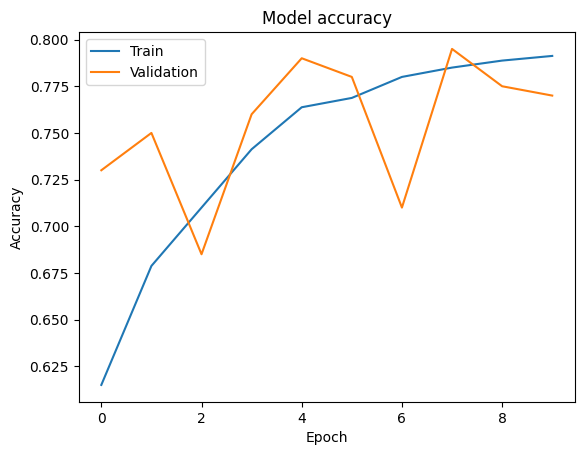

In [38]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()